In [108]:
import sys
sys.path.append('./support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from sampler import fitters
from astropy.coordinates import SkyCoord
from astropy.table import Table
import GCRCatalogs

### Read in the extragalactic catalog
- identify the most massive halo
- create a cluster dictionary (ra, dec, z)

In [109]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [110]:
stacked_gt = []
stacked_gterr = []
cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

In [111]:
# get a massive halo at intermediate redshift
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=['halo_mass > 1e14','halo_mass < 125892541179416.62','is_central==True','redshift>0.3','redshift<0.35'])

mass_list = massive_halos['halo_mass']
select = (mass_list == mass_list)

In [117]:
len(mass_list)

15

In [113]:
for i in range(len(select)):
    
    print(i)
    ra_cl = massive_halos['ra'][select][i]
    dec_cl = massive_halos['dec'][select][i]
    z_cl = massive_halos['redshift'][select][i]
    mass_cl = mass_list[select][i]

    print("mass = ", mass_cl/1e14,"*1e14 Msol\n", "\n ra = ", ra_cl, "\n dec = ", dec_cl,"\n z = ", z_cl)

    # get galaxies around it
    ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
    dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
    z_min = z_cl + 0.1
    z_max = 1.5

    coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]

    z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

    gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2', 'shear_2_phosim', 'shear_2_treecorr',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))


    
    # store the results into an astropy table
    dat = Table([gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
          gal_cat['shear_2'],gal_cat['redshift'],gal_cat['galaxy_id']], \
          names=('ra','dec', 'e1', 'e2', 'z','id'))
                
    my_cl = clmm.GalaxyCluster('CL', ra_cl, dec_cl,
                               z_cl, dat)

    
    print ("number of galaxies selected = ", len(dat))
    
    
    my_cl.compute_shear(geometry="flat")
    bin_edges = pa.make_bins(0.1, 4, 15, method='evenlog10width')
    profile = my_cl.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
    
    
    stacked_gt.append(profile['gt'])
    stacked_gterr.append(profile['gt_err'])

0
mass =  1.074492072743662 *1e14 Msol 
 ra =  64.18873612123166 
 dec =  -39.68780413277255 
 z =  0.3395830652891523
number of galaxies selected =  443458
1
mass =  1.06224943104 *1e14 Msol 
 ra =  63.91943801550073 
 dec =  -41.698931058314194 
 z =  0.33512327088586336
number of galaxies selected =  415294
2
mass =  1.058194543341972 *1e14 Msol 
 ra =  69.69666762324073 
 dec =  -42.94997772427642 
 z =  0.31419019612826826
number of galaxies selected =  319617
3
mass =  1.0916213739808451 *1e14 Msol 
 ra =  68.368691372601 
 dec =  -44.45895572201655 
 z =  0.31397281823785295
number of galaxies selected =  405710
4
mass =  1.13606918144 *1e14 Msol 
 ra =  68.54517686354546 
 dec =  -44.35041916292372 
 z =  0.3117652953385337
number of galaxies selected =  404835
5
mass =  1.1556158195740844 *1e14 Msol 
 ra =  66.90461276350621 
 dec =  -45.279033062083556 
 z =  0.32970929417898986
number of galaxies selected =  375405
6
mass =  1.0649786823752112 *1e14 Msol 
 ra =  64.897650517

### Build the corresponding theoretical prediction from the average cluster mass.

In [114]:
m = np.mean(mass_list[0:3])
gt_model = np.zeros(len(profile))
for i,r in enumerate(profile['radius']):   
    gt_mod = clmm.predict_reduced_tangential_shear(r*cosmo.h,m, 4.,z_cl, dat['z'], cosmo,
                                                        delta_mdef=200,halo_profile_model='nfw')  
    gt_model[i] = np.mean(gt_mod)

# LET'S STACK !!!

### Eq 34 in https://arxiv.org/pdf/1802.09696.pdf

$w(z_l,z_s) \gamma_T(\theta,z_s)$

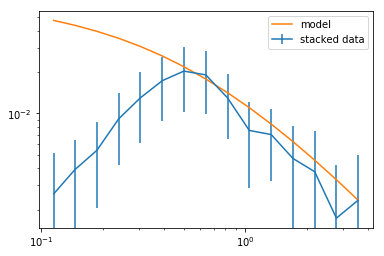

In [115]:
plt.errorbar(profile['radius'],np.nanmean(stacked_gt,axis=0),yerr=np.nanstd(stacked_gt,axis=0), label='stacked data')
plt.plot(profile['radius'],gt_model, label='model')
plt.legend()
plt.xscale('log')
plt.yscale('log')